# deconvolution with LSVR

In [1]:
import sys
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import glob
sys.path.append('../src')
from lsvr import run_multiprocess_deconvolution
from utils import load_cell_to_group, zhu_ref_data
import plotly.express as px

marker_genes_convert = load_cell_to_group()

In [2]:
from itertools import combinations, permutations
import random

def run_one_lsvr(target_df, timepoints, param_C=0.001, param_e=0.1, min_marker=0, min_markerscore=0.05):
    markers = pd.read_csv('../data/top_100_markers_postsub.csv', index_col=None, header=0)
    markers = markers[markers['marker_score'] > min_markerscore]

    bulk_protein_matrix = target_df[[x for x in target_df.columns if len(x) > 0]]
    bulk_protein_matrix = bulk_protein_matrix.T.reindex(set(markers['gene_id'])).T
    bulk_protein_matrix = bulk_protein_matrix.dropna(axis=1, how='all')

    marker_genes = {}
    exp_level = {}
    last_type = ''
    for i, row in markers.iterrows():
        if row['gene_id'] not in bulk_protein_matrix.columns:
            continue
            
        exp_level[row['gene_id']] = row['mean_expression']
        last_type = row['cell_group']
        if last_type in marker_genes.keys():
            marker_genes[last_type].extend([row['gene_id']])
        else:
            marker_genes[last_type] = [row['gene_id']]
    

    #markers['weighted_mean_expression'] = markers['marker_score'] * markers['mean_expression']
    # --- Marker genes and existing genes
    reference_df = markers.pivot_table(
            index=['gene_id'], # Use both gene IDs for better indexing
            columns='cell_group',
            values='mean_expression'
        )
    reference_df = reference_df.reindex(bulk_protein_matrix.columns.intersection(reference_df.index))
    reference_df[reference_df.isna()] = 0
    reference_df = reference_df.loc[:, (reference_df>0).sum(axis=0)>min_marker] #################### CUTOFF

    #  Run Deconvolution
    final_proportions_df = run_multiprocess_deconvolution(
        bulk_protein_matrix, 
        reference_df,
        max_workers=18 # Use all available cores
    )
    
    # Concatenate the results into a single DataFrame for final output
    final_df = pd.concat(final_proportions_df, axis=1).T
    final_df.index = bulk_protein_matrix.index
    
    final_df['timepoints'] = timepoints
    
    return final_df

In [7]:
x = sns.color_palette("Set1", 8)
gray = sns.color_palette("gist_yarg", 15)

color_target = ['Germline', 'Glia', 'Gonadal', 'Intestine', 'Muscle',
       'Neurons', 'Uterine-vulval cells', 'vulval cells and the epidermis',]

# Single-worm Proteomics by Zhu et  al

In [28]:
min_marker = 5
min_markerscore = 0.08

In [30]:
target_df, time_points = zhu_ref_data()
target_df = target_df.loc[:,~target_df.isnull().values.all(axis=0)]
target_df = target_df.astype(np.float32)
#time_points = [int(x.split('_')[1]) for x in target_df.index]

final_df = run_one_lsvr(target_df, time_points, param_C=0.01, param_e=0.1,  min_marker=5, min_markerscore=0.08)
final_df.to_csv(f'../results/Zhu_N2_proportion_minnum_{min_marker}_minscore_{min_markerscore}.csv')

/home/youngjunpark/Git/deconvolution_C_elegans/notebooks/../src/utils.py:23: DtypeWarning: Columns (830,831) have mixed types. Specify dtype option on import or set low_memory=False.
  target_df = pd.read_csv(filepath, header=0, index_col=5, sep='\t')
Deconvoluting Samples: 100%|███████████████████████████████████████████████████████| 101/101 [00:00<00:00, 1336.25it/s]


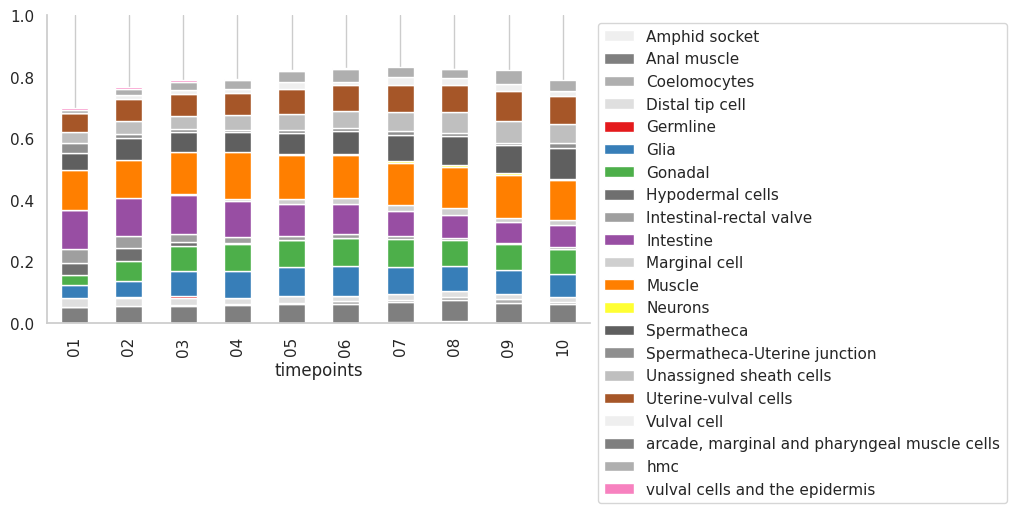

In [34]:
final_df = pd.read_csv(f'../results/Zhu_N2_proportion_minnum_{min_marker}_minscore_{min_markerscore}.csv', index_col=0, header=0)

# Aggregate
final_df = final_df.T
final_df['group'] = final_df.index
final_df['group'] = final_df['group'].map(marker_genes_convert)
final_df['group'] = [x.split(' is ')[0] if type(x) is str and "These gene" not in x else x for x in final_df['group']]
final_df = final_df.groupby('group').agg('sum')
final_df = final_df.T

final_df['timepoints'] = [(x.split('_')[-2].split(' ')[-1]).lstrip('D').zfill(2) for x in final_df.index]

target_columns = final_df.columns[:-1]
target_columns = final_df.groupby('timepoints').mean().mean().index[final_df.groupby('timepoints').mean().mean() > 0.0]

color_map = []
color_idx = 0
gray_idx = 0
all_columns = target_columns
for i in iter(all_columns):
    if i in color_target:
        color_map.append(x[color_idx])
        color_idx+=1
    else:
        color_map.append(gray[(7*gray_idx)%10])
        gray_idx+=1

g = final_df.groupby('timepoints').mean()[target_columns].plot(kind='bar', stacked=True, figsize=(7,4), color=color_map)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
g.axes.set_ylim((0,1))
g.axes.spines['top'].set_visible(False)
g.axes.spines['right'].set_visible(False)
g.axes.get_xaxis().set_visible(True)
plt.grid(axis='y')

final_df.groupby('timepoints').mean().T.to_csv(f'../results/Zhu_plot_data_minnum_{min_marker}_minscore_{min_markerscore}.csv')
plt.savefig(f'../results/Zhu_proportion_minnum_{min_marker}_minscore_{min_markerscore}.svg', bbox_inches='tight')

    timepoints                           group     value
0           01                   Amphid socket  0.002653
1           02                   Amphid socket  0.000000
2           03                   Amphid socket  0.000031
3           04                   Amphid socket  0.001462
4           05                   Amphid socket  0.002751
..         ...                             ...       ...
205         06  vulval cells and the epidermis  0.003684
206         07  vulval cells and the epidermis  0.000000
207         08  vulval cells and the epidermis  0.000979
208         09  vulval cells and the epidermis  0.000000
209         10  vulval cells and the epidermis  0.000000

[210 rows x 3 columns]


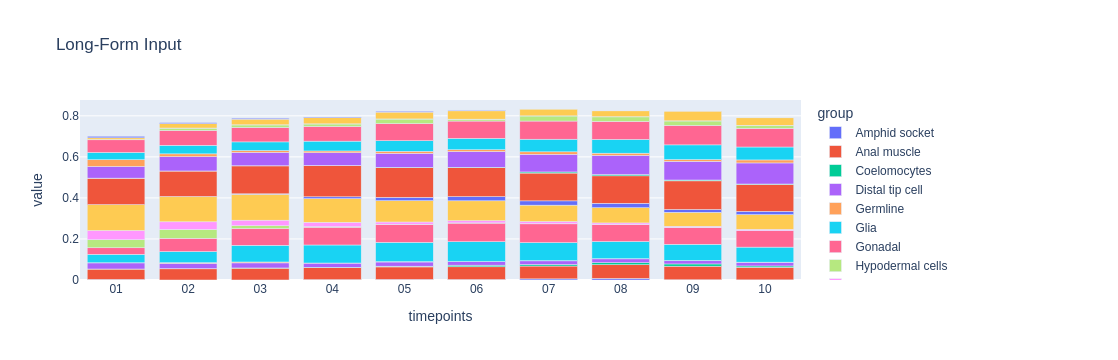

In [5]:
long_df = final_df.groupby('timepoints').mean()[target_columns].reset_index().melt(id_vars='timepoints')
print(long_df)
fig = px.bar(long_df, x="timepoints", y="value", color="group", title="Long-Form Input")
fig.show()

In [32]:
# correlation of samples from same days
final_df = pd.read_csv(f'../results/Zhu_N2_proportion_minnum_{min_marker}_minscore_{min_markerscore}.csv', index_col=0, header=0)

# Aggregate
bk = final_df['timepoints']
final_df = final_df.T
final_df['group'] = final_df.index
final_df['group'] = final_df['group'].map(marker_genes_convert)
final_df['group'] = [x.split(' is ')[0].split(' are ')[0] if type(x) is str and "These gene" not in x else x for x in final_df['group']]
final_df = final_df.groupby('group').agg('sum')
final_df = final_df.T
final_df['timepoints'] = bk

for_plot=[]
for timepoint, _x in final_df.groupby('timepoints'):
    results = []
    for _i, _j in (permutations(range(len(_x)), 2)):
        corr_x = _x.values[_i, :]        
        corr_y = _x.values[_j, :]
        
        corr_res = stats.spearmanr(list(corr_x), list(corr_y))
        results.append(corr_res[0])
        if len(results) >= 200:
            break
            
    for_plot.append(results)
    print(f"day {timepoint}: \t {np.mean(results)}")

# Random pair correlation

results=[]
for _i, _j in tqdm(permutations(range(len(final_df)), 2)):
    corr_x = final_df.values[_i, :-1]        
    corr_y = final_df.values[_j, :-1]
    
    corr_res = stats.spearmanr(list(corr_x), list(corr_y))
    results.append(corr_res[0])
    if len(results) >= 100000:
        break
print(f"Random pair correlation: \t{np.mean(results)}")

day 1: 	 0.9359551309403681
day 2: 	 0.959936765395486
day 3: 	 0.9307697329454365
day 4: 	 0.9344028526066617
day 5: 	 0.9326149447304002
day 6: 	 0.9386482922840542
day 7: 	 0.9509860921986453
day 8: 	 0.9211431196879704
day 9: 	 0.9377824270862328
day 10: 	 0.9140146759315149


0it [00:00, ?it/s]

Random pair correlation: 	0.8566963318316904


/tmp/ipykernel_648586/2803316462.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


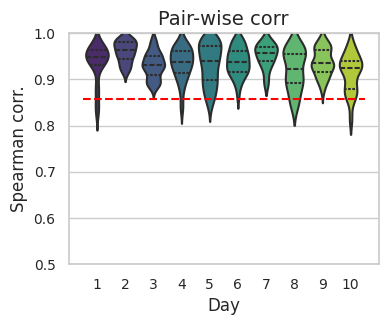

In [33]:
to_melt = pd.DataFrame(for_plot).T
to_melt.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',]
df_long = to_melt.melt()

# Convert 'Set' to string for categorical plotting
df_long['variable'] = df_long['variable'].astype(str)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(4, 3))

sns.violinplot(
    x='variable', 
    y='value', 
    data=df_long, 
    palette='viridis', 
    inner='quartile',  # Shows quartiles (median, Q1, Q3) inside the violin
    linewidth=1.5
)

# Add plot titles and labels for clarity
plt.title('Pair-wise corr', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Spearman corr.', fontsize=12)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.hlines(y=np.mean(results), xmin=-0.5, xmax=9.5, colors='red', linestyles='--')
plt.ylim((0.5,1))
plt.savefig(f'../results/Zhu_corr_minnum_{min_marker}_minscore_{min_markerscore}.svg')
plt.show()

# swRNAseq N2

In [35]:
min_marker = 0
min_markerscore = 0.08

In [25]:
swRNAseq_df = pd.read_hdf('../data/swRNAseq/swRNAseq_N2_norm.h5', index_col=0, header=0)
swRNAseq_df = swRNAseq_df.loc[:, np.sum(swRNAseq_df>0, axis=0) > 10000]
swRNAseq_df = swRNAseq_df.div(np.sum(swRNAseq_df,axis=0), axis=1) *1e5
timepoints2 = [int(x.split('_')[1]) for x in swRNAseq_df.columns]
swRNAseq_df = swRNAseq_df.T
swRNAseq_df

,WBGene00000001,WBGene00000002,WBGene00000003,WBGene00000004,WBGene00000005,WBGene00000006,WBGene00000007,WBGene00000008,WBGene00000009,WBGene00000010,...,WBGene00306004,WBGene00306005,WBGene00306012,WBGene00306013,WBGene00306014,WBGene00306070,WBGene00306076,WBGene00306080,WBGene00306081,WBGene00306121
N2_10_QZ0_20.Rep_1,2.774802,0.904892,0.689876,0.855877,0.786533,0.117378,0.254378,0.664307,0.691281,1.873432,...,0.422561,0.000000,1.387676,10.392236,2.864649,9.975365,0.000000,0.358160,0.269117,0.580957
N2_10_QZ0_20.Rep_10,3.808191,0.249879,0.875119,2.140557,0.000000,0.372149,0.427132,0.343530,0.394492,2.291008,...,0.146231,0.618454,0.188927,8.215322,0.000000,0.000000,0.000000,0.239510,0.095065,0.367434
N2_10_QZ0_20.Rep_11,5.746129,0.141667,0.407543,0.773874,0.085103,0.000000,0.139414,0.058426,0.079588,2.689932,...,0.165563,0.000000,0.427865,7.247283,0.972538,5.712582,0.000000,0.812670,0.000000,0.130820
N2_10_QZ0_20.Rep_12,3.827738,0.131473,0.745478,1.001076,0.252681,0.363313,0.099954,0.096449,0.098550,1.799788,...,0.000000,0.000000,0.543986,5.228450,2.630595,3.175490,0.000000,0.347191,0.000000,0.194466
N2_10_QZ0_20.Rep_13,4.696136,0.302655,0.454266,0.701370,0.096944,0.152373,0.172591,0.000000,0.056721,2.568437,...,0.000000,0.523868,0.942854,2.861591,0.000000,3.667869,0.000000,0.401818,0.000000,0.083164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N2_8_QZ0_20.Rep_974,3.319885,0.285095,0.618089,0.755103,0.000000,0.160480,0.270632,0.156734,0.600202,0.859840,...,0.440384,0.461524,1.702101,9.752090,0.000000,9.407262,0.460193,0.358755,0.143793,0.471919
N2_8_QZ0_20.Rep_975,3.972851,0.183515,0.642704,1.389745,0.176353,0.213112,0.235433,0.075726,0.283710,2.207623,...,0.109384,0.236549,0.142300,1.727426,0.697507,3.334834,0.114496,8.178717,0.211579,0.134116
N2_8_QZ0_20.Rep_976,4.284447,0.331517,0.539054,1.111196,0.000000,0.000000,0.803905,0.501837,0.466205,1.895240,...,0.201312,0.000000,0.527400,10.408002,4.059076,0.000000,0.210931,0.339163,1.930624,0.334548
N2_8_QZ0_20.Rep_977,3.896854,0.183952,0.713264,0.502362,0.000000,0.423699,0.525520,0.050679,0.051801,0.753497,...,0.230854,0.254735,6.375530,122.747879,12.879270,1.561916,0.000000,0.000000,0.072913,0.590696


In [26]:
final_df = run_one_lsvr(swRNAseq_df, timepoints2, param_C=0.001, param_e=0.01,  min_marker=min_marker, min_markerscore=min_markerscore)
final_df.to_csv(f'../results/swRNAseq_N2_proportion_minnum_{min_marker}_minscore_{min_markerscore}.csv')

Deconvoluting Samples: 100%|███████████████████████████████████████████████████████| 1836/1836 [00:33<00:00, 54.94it/s]


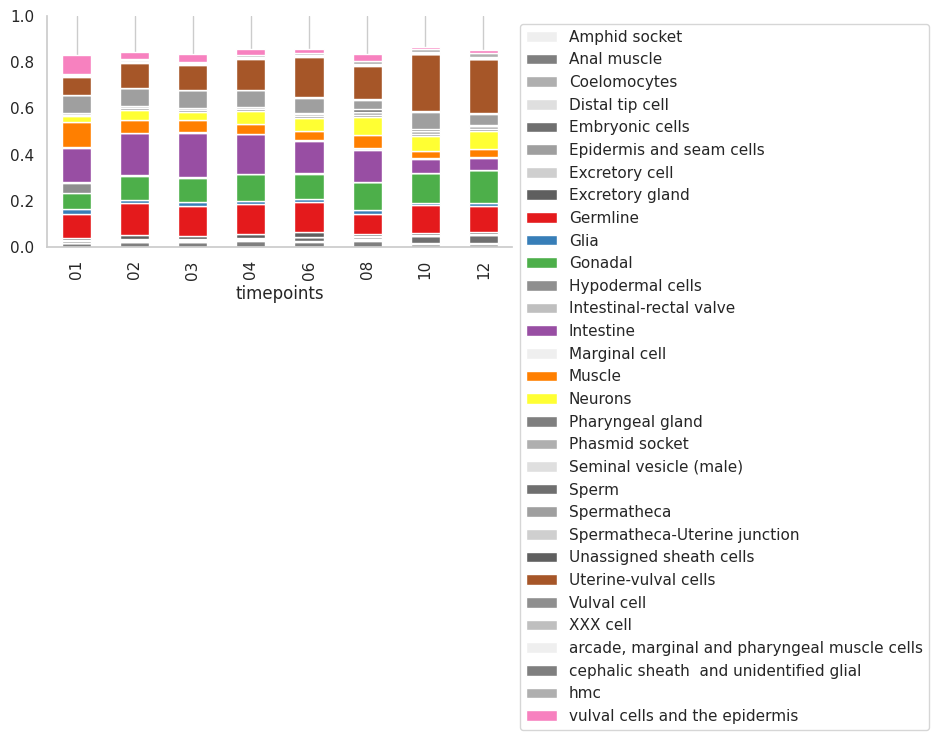

In [36]:
final_df = pd.read_csv(f'../results/swRNAseq_N2_proportion_minnum_{min_marker}_minscore_{min_markerscore}.csv', index_col=0, header=0)

# Aggregate
final_df = final_df.T
final_df['group'] = final_df.index
final_df['group'] = final_df['group'].map(marker_genes_convert)
final_df['group'] = [x.split(' is ')[0] if type(x) is str and "These gene" not in x else x for x in final_df['group']]
final_df = final_df.groupby('group').agg('sum')
final_df = final_df.T


final_df['timepoints'] = [(x.split('_')[1]).zfill(2) for x in final_df.index]

target_columns = final_df.groupby('timepoints').mean().mean().index[final_df.groupby('timepoints').mean().mean() > 0.00]

color_map = []
color_idx = 0
gray_idx = 0
all_columns = final_df[final_df['timepoints']=='01']
for i in iter(all_columns):
    if i in color_target:
        color_map.append(x[color_idx])
        color_idx+=1
    else:
        color_map.append(gray[(7*gray_idx)%10])
        gray_idx+=1
        
g = final_df.groupby('timepoints').mean()[target_columns].plot(kind='bar', stacked=True, figsize=(6,3), color=color_map)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
g.axes.set_ylim((0,1))
g.axes.spines['top'].set_visible(False)
g.axes.spines['right'].set_visible(False)
g.axes.get_xaxis().set_visible(True)
plt.grid(axis='y')
plt.savefig(f'../results/swRNA_N2_proportion_minnum_{min_marker}_minscore_{min_markerscore}.svg', bbox_inches='tight')

final_df.groupby('timepoints').mean().T.to_csv(f'../results/swRNA_N2_plot_data_minnum_{min_marker}_minscore_{min_markerscore}.csv')
swRNAseq_N2_df = final_df

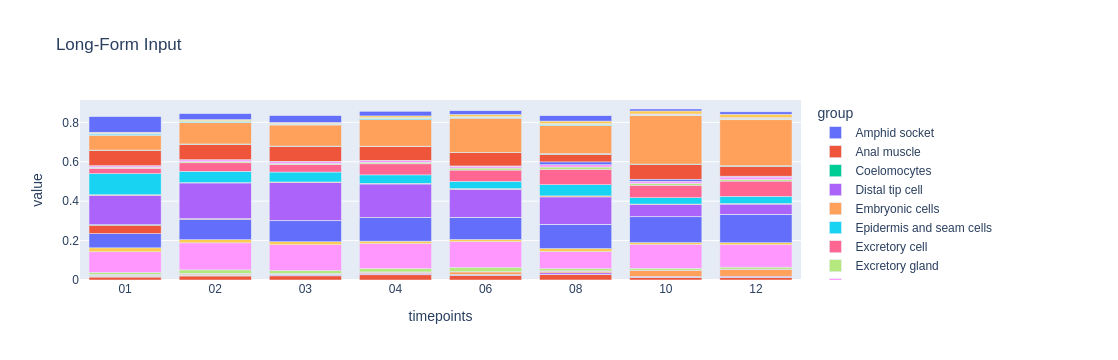

In [34]:
long_df = final_df.groupby('timepoints').mean()[target_columns].reset_index().melt(id_vars='timepoints')
fig = px.bar(long_df, x="timepoints", y="value", color="group", title="Long-Form Input")
fig.show()

In [37]:
# correlation of samples from same days
final_df = pd.read_csv(f'../results/swRNAseq_N2_proportion_minnum_{min_marker}_minscore_{min_markerscore}.csv', index_col=0, header=0)

# Aggregate
bk = final_df['timepoints']
final_df = final_df.T
final_df['group'] = final_df.index
final_df['group'] = final_df['group'].map(marker_genes_convert)
final_df['group'] = [x.split(' is ')[0].split(' are ')[0] if type(x) is str and "These gene" not in x else x for x in final_df['group']]
final_df = final_df.groupby('group').agg('sum')
final_df = final_df.T
final_df['timepoints'] = bk

for_plot=[]
for timepoint, _x in final_df.groupby('timepoints'):
    results = []
    for _i, _j in (permutations(range(len(_x)), 2)):
        corr_x = _x.values[_i, :]        
        corr_y = _x.values[_j, :]
        
        corr_res = stats.spearmanr(list(corr_x), list(corr_y))
        results.append(corr_res[0])
        if len(results) >= 200:
            break
            
    for_plot.append(results)
    print(f"day {timepoint}: \t {np.mean(results)}")

# Random pair correlation

results=[]
for _i, _j in tqdm(permutations(range(len(final_df)), 2)):
    corr_x = final_df.values[_i, :-1]        
    corr_y = final_df.values[_j, :-1]
    
    corr_res = stats.spearmanr(list(corr_x), list(corr_y))
    results.append(corr_res[0])
    if len(results) >= 100000:
        break
print(f"Random pair correlation: \t{np.mean(results)}")

day 1: 	 0.9337377946494787
day 2: 	 0.928229272820629
day 3: 	 0.9443657874387484
day 4: 	 0.9722224956264021
day 6: 	 0.9380502153022566
day 8: 	 0.8738581692488787
day 10: 	 0.9004410119950831
day 12: 	 0.8982815813699705


0it [00:00, ?it/s]

Random pair correlation: 	0.7777184314996678


/tmp/ipykernel_648586/1467704417.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


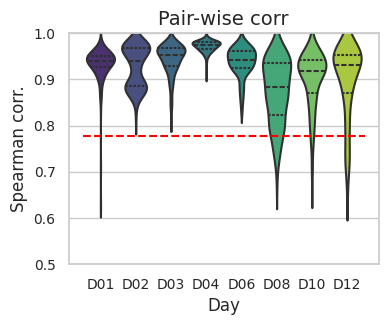

In [39]:
to_melt = pd.DataFrame(for_plot).T
to_melt.columns = ['D01', 'D02', 'D03', 'D04', 'D06', 'D08', 'D10', 'D12']
df_long = to_melt.melt()

# Convert 'Set' to string for categorical plotting
df_long['variable'] = df_long['variable'].astype(str)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(4, 3))

sns.violinplot(
    x='variable', 
    y='value', 
    data=df_long, 
    palette='viridis', 
    inner='quartile',  # Shows quartiles (median, Q1, Q3) inside the violin
    linewidth=1.5
)

# Add plot titles and labels for clarity
plt.title('Pair-wise corr', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Spearman corr.', fontsize=12)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.hlines(y=np.mean(results), xmin=-0.5, xmax=7.5, colors='red', linestyles='--')
plt.ylim((0.5,1))
plt.savefig(f'../results/swRNAseq_N2_corr_minnum_{min_marker}_minscore_{min_markerscore}.svg')
plt.show()

# swRNAseq glp-1

In [40]:
min_marker = 0
min_markerscore = 0.08

In [41]:
swRNAseq_df = pd.read_hdf('../data/swRNAseq/swRNAseq_glp1_norm.h5', index_col=0, header=0)
swRNAseq_df = swRNAseq_df.loc[:, np.sum(swRNAseq_df>0, axis=0) > 10000]
swRNAseq_df = swRNAseq_df.div(np.sum(swRNAseq_df,axis=0), axis=1) *1e5

timepoints2 = [int(x.split('_')[3]) for x in swRNAseq_df.columns]
swRNAseq_df = swRNAseq_df.T

In [42]:
final_df = run_one_lsvr(swRNAseq_df, timepoints2, param_C=0.001, param_e=0.01,  min_marker=0, min_markerscore=0.08)
final_df.to_csv(f'../results/swRNAseq_glp1_proportion_minnum_{min_marker}_minscore_{min_markerscore}.csv')

Deconvoluting Samples: 100%|█████████████████████████████████████████████████████████| 175/175 [00:07<00:00, 24.38it/s]


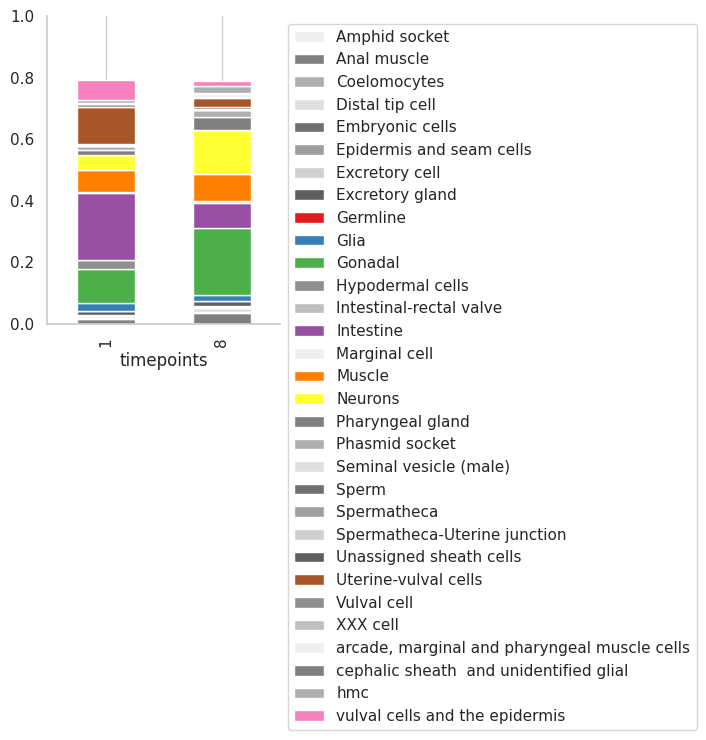

In [43]:
final_df = pd.read_csv(f'../results/swRNAseq_glp1_proportion_minnum_{min_marker}_minscore_{min_markerscore}.csv', index_col=0, header=0)


# Aggregate
final_df = final_df.T
final_df['group'] = final_df.index
final_df['group'] = final_df['group'].map(marker_genes_convert)
final_df['group'] = [x.split(' is ')[0].split(' are ')[0] if type(x) is str and "These gene" not in x else x for x in final_df['group']]
final_df = final_df.groupby('group').agg('sum')
final_df = final_df.T

final_df['timepoints'] = timepoints2

target_columns = final_df.columns[:-1]

color_map = []
color_idx = 0
gray_idx = 0
all_columns = target_columns
for i in iter(all_columns):
    if i in color_target:
        color_map.append(x[color_idx])
        color_idx+=1
    else:
        color_map.append(gray[(7*gray_idx)%10])
        gray_idx+=1
        
g = final_df.groupby('timepoints').mean()[target_columns].plot(kind='bar', stacked=True, figsize=(3,4), color=color_map)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
g.axes.set_ylim((0,1))
g.axes.spines['top'].set_visible(False)
g.axes.spines['right'].set_visible(False)
g.axes.get_xaxis().set_visible(True)
plt.grid(axis='y')
plt.savefig(f'../results/swRNA_glp-1_proportion_minnum_{min_marker}_minscore_{min_markerscore}.svg')

final_df.groupby('timepoints').mean().T.to_csv(f'../results/swRNAseq_glp1_plot_data_minnum_{min_marker}_minscore_{min_markerscore}.csv')

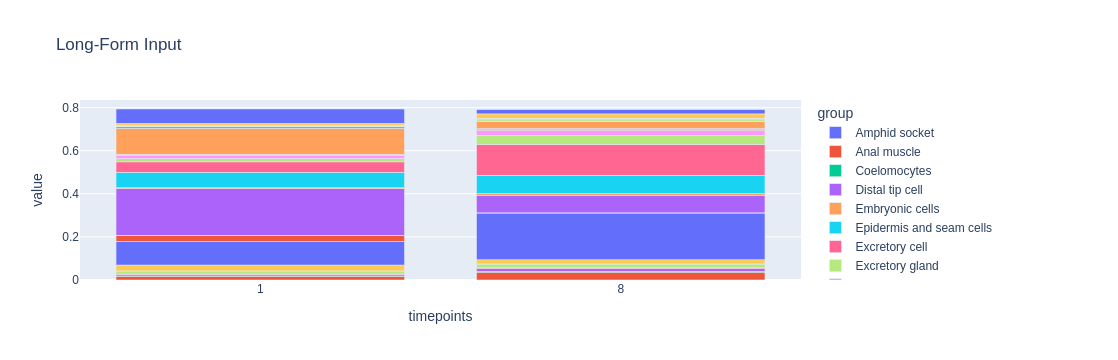

In [12]:
long_df = final_df.groupby('timepoints').mean()[target_columns].reset_index().melt(id_vars='timepoints')
fig = px.bar(long_df, x="timepoints", y="value", color="group", title="Long-Form Input")
fig.show()

In [44]:
# correlation of samples from same days
final_df = pd.read_csv(f'../results/swRNAseq_glp1_proportion_minnum_{min_marker}_minscore_{min_markerscore}.csv', index_col=0, header=0)

# Aggregate
bk = final_df['timepoints']
final_df = final_df.T
final_df['group'] = final_df.index
final_df['group'] = final_df['group'].map(marker_genes_convert)
final_df['group'] = [x.split(' is ')[0].split(' are ')[0] if type(x) is str and "These gene" not in x else x for x in final_df['group']]
final_df = final_df.groupby('group').agg('sum')
final_df = final_df.T
final_df['timepoints'] = bk

for_plot=[]
for timepoint, _x in final_df.groupby('timepoints'):
    results = []
    for _i, _j in (permutations(range(len(_x)), 2)):
        corr_x = _x.values[_i, :]        
        corr_y = _x.values[_j, :]
        
        corr_res = stats.spearmanr(list(corr_x), list(corr_y))
        results.append(corr_res[0])
        if len(results) >= 200:
            break
            
    for_plot.append(results)
    print(f"day {timepoint}: \t {np.mean(results)}")

# Random pair correlation

results=[]
for _i, _j in tqdm(permutations(range(len(final_df)), 2)):
    corr_x = final_df.values[_i, :-1]        
    corr_y = final_df.values[_j, :-1]
    
    corr_res = stats.spearmanr(list(corr_x), list(corr_y))
    results.append(corr_res[0])
    if len(results) >= 100000:
        break
print(f"Random pair correlation: \t{np.mean(results)}")

day 1: 	 0.9522720944038521
day 8: 	 0.9482779556012786


0it [00:00, ?it/s]

Random pair correlation: 	0.8584395439872294


/tmp/ipykernel_648586/2288902995.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


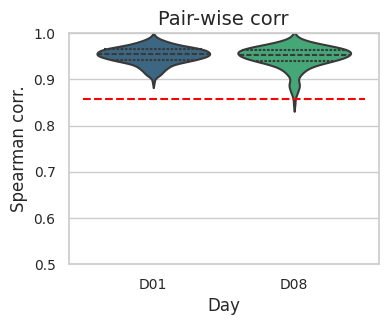

In [45]:
to_melt = pd.DataFrame(for_plot).T
to_melt.columns = ['D01', 'D08', ]
df_long = to_melt.melt()

# Convert 'Set' to string for categorical plotting
df_long['variable'] = df_long['variable'].astype(str)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(4, 3))

sns.violinplot(
    x='variable', 
    y='value', 
    data=df_long, 
    palette='viridis', 
    inner='quartile',  # Shows quartiles (median, Q1, Q3) inside the violin
    linewidth=1.5
)

# Add plot titles and labels for clarity
plt.title('Pair-wise corr', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Spearman corr.', fontsize=12)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.hlines(y=np.mean(results), xmin=-0.5, xmax=1.5, colors='red', linestyles='--')
plt.ylim((0.5,1))
plt.savefig(f'../results/swRNAseq_glp1_corr_minnum_{min_marker}_minscore_{min_markerscore}.svg')
plt.show()